# 라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 랜덤 시드 설정

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [3]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')
interestRate = pd.read_csv('../data/interestRate.csv')

In [4]:
train_data = train_data.merge(interestRate, left_on='contract_year_month', right_on='year_month', how='left')
train_data.drop(columns=['year_month'], inplace=True)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801228 entries, 0 to 1801227
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   index                int64  
 1   area_m2              float64
 2   contract_year_month  int64  
 3   contract_day         int64  
 4   contract_type        int64  
 5   floor                int64  
 6   built_year           int64  
 7   latitude             float64
 8   longitude            float64
 9   age                  int64  
 10  deposit              float64
 11  interest_rate        float64
dtypes: float64(5), int64(7)
memory usage: 164.9 MB


In [6]:
train_data.describe()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,interest_rate
count,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06
mean,9.006135e+05,7.518833e+01,2.021331e+05,1.589943e+01,1.203805e+00,1.005197e+01,2.004199e+03,3.747721e+01,1.269662e+02,1.706597e+01,3.816223e+04,2.157603e+00
std,5.199699e+05,2.552632e+01,1.352815e+02,8.625998e+00,8.852792e-01,6.973359e+00,1.115132e+01,1.625113e-01,1.701221e-01,1.112796e+01,2.610377e+04,1.191301e+00
min,0.000000e+00,1.032150e+01,2.019040e+05,1.000000e+00,0.000000e+00,-4.000000e+00,1.961000e+03,3.691791e+01,1.264787e+02,-3.000000e+00,3.000000e+02,8.000000e-01
25%,4.503068e+05,5.975000e+01,2.020080e+05,9.000000e+00,0.000000e+00,5.000000e+00,1.995000e+03,3.737976e+01,1.268422e+02,7.000000e+00,2.100000e+04,1.060000e+00
50%,9.006135e+05,7.715000e+01,2.021110e+05,1.600000e+01,2.000000e+00,9.000000e+00,2.004000e+03,3.750227e+01,1.269976e+02,1.700000e+01,3.200000e+04,1.690000e+00
75%,1.350920e+06,8.496000e+01,2.022120e+05,2.300000e+01,2.000000e+00,1.400000e+01,2.015000e+03,3.758205e+01,1.270888e+02,2.600000e+01,4.780000e+04,3.560000e+00
max,1.801227e+06,3.173600e+02,2.023120e+05,3.100000e+01,2.000000e+00,6.800000e+01,2.024000e+03,3.818194e+01,1.276609e+02,6.200000e+01,1.100000e+06,4.340000e+00


## EDA

### 데이터 분포 확인

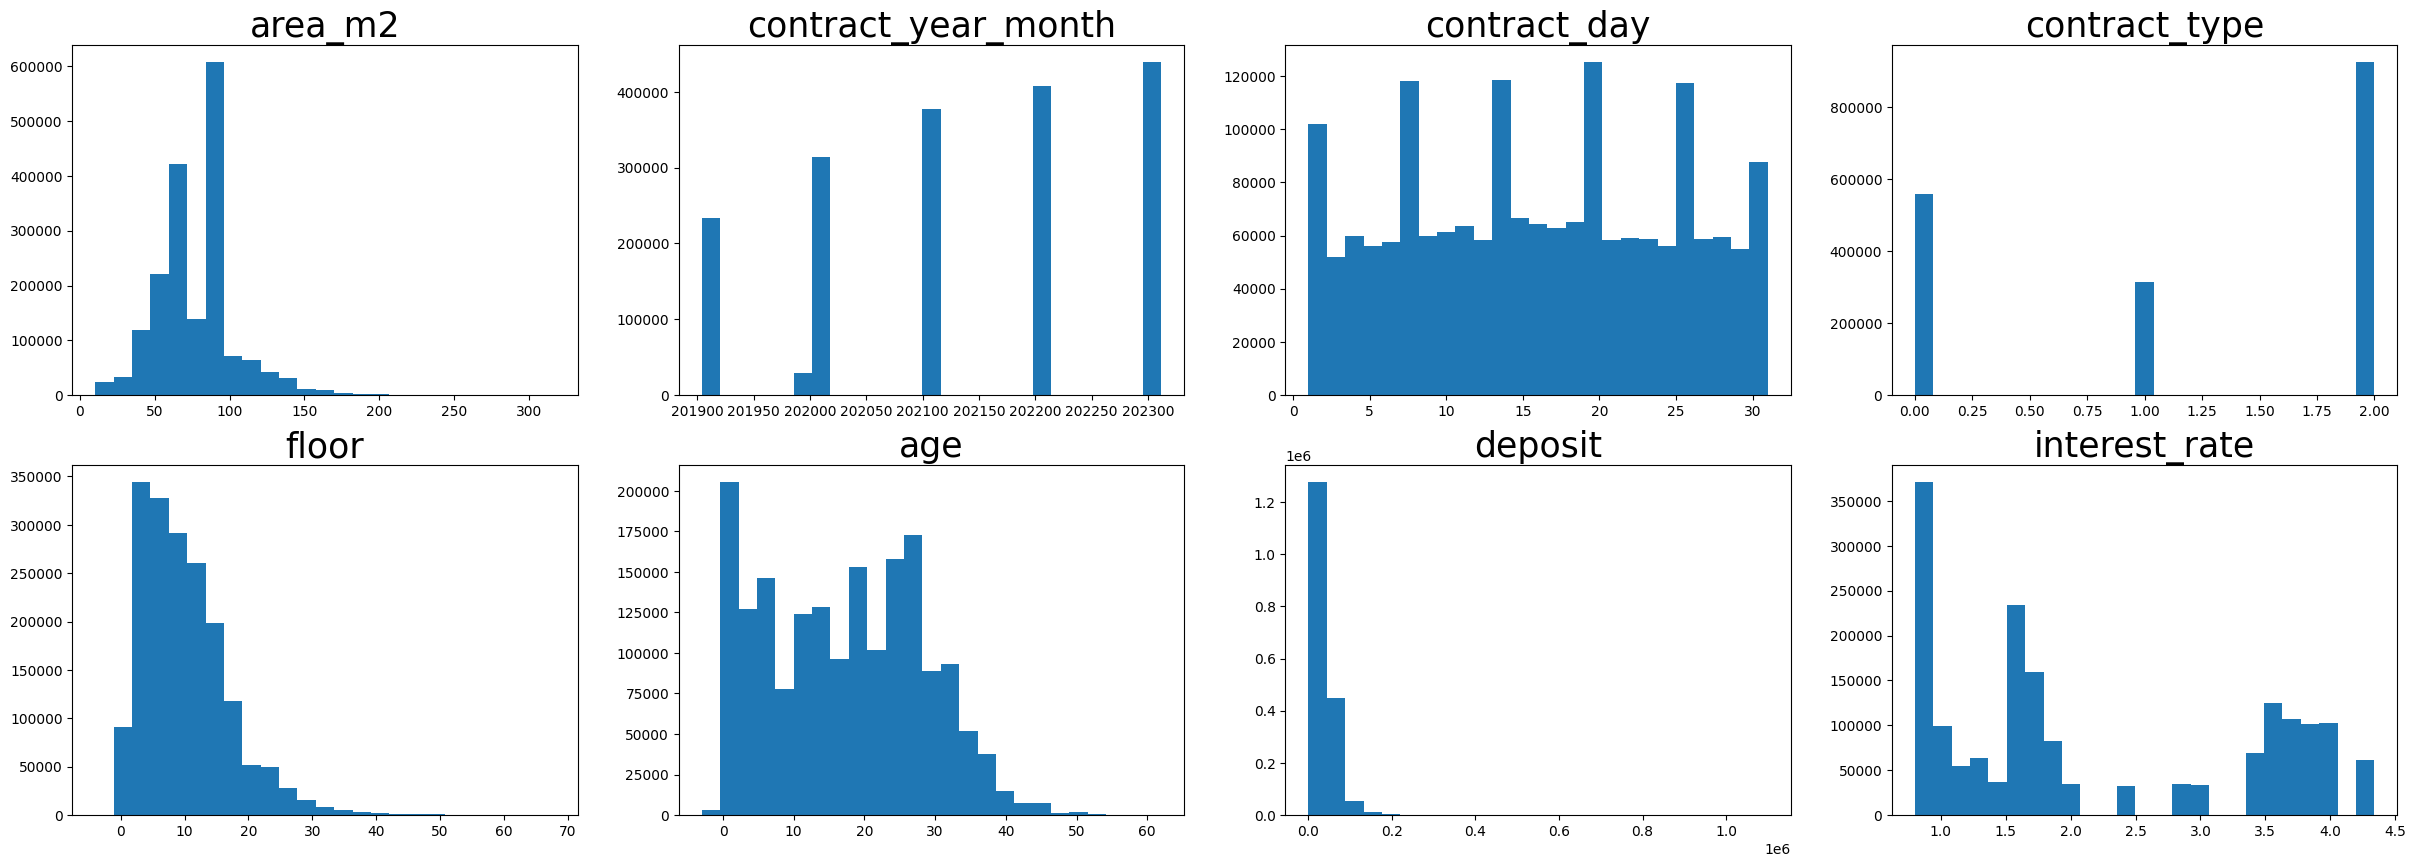

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 10))
axes = axes.flatten()

for i, column in enumerate(train_data.drop(columns=['index', 'longitude', 'latitude', 'built_year']).columns):
    axes[i].hist(train_data[column], bins=25)
    axes[i].set_title(column, fontsize=25)

### 이상치 확인

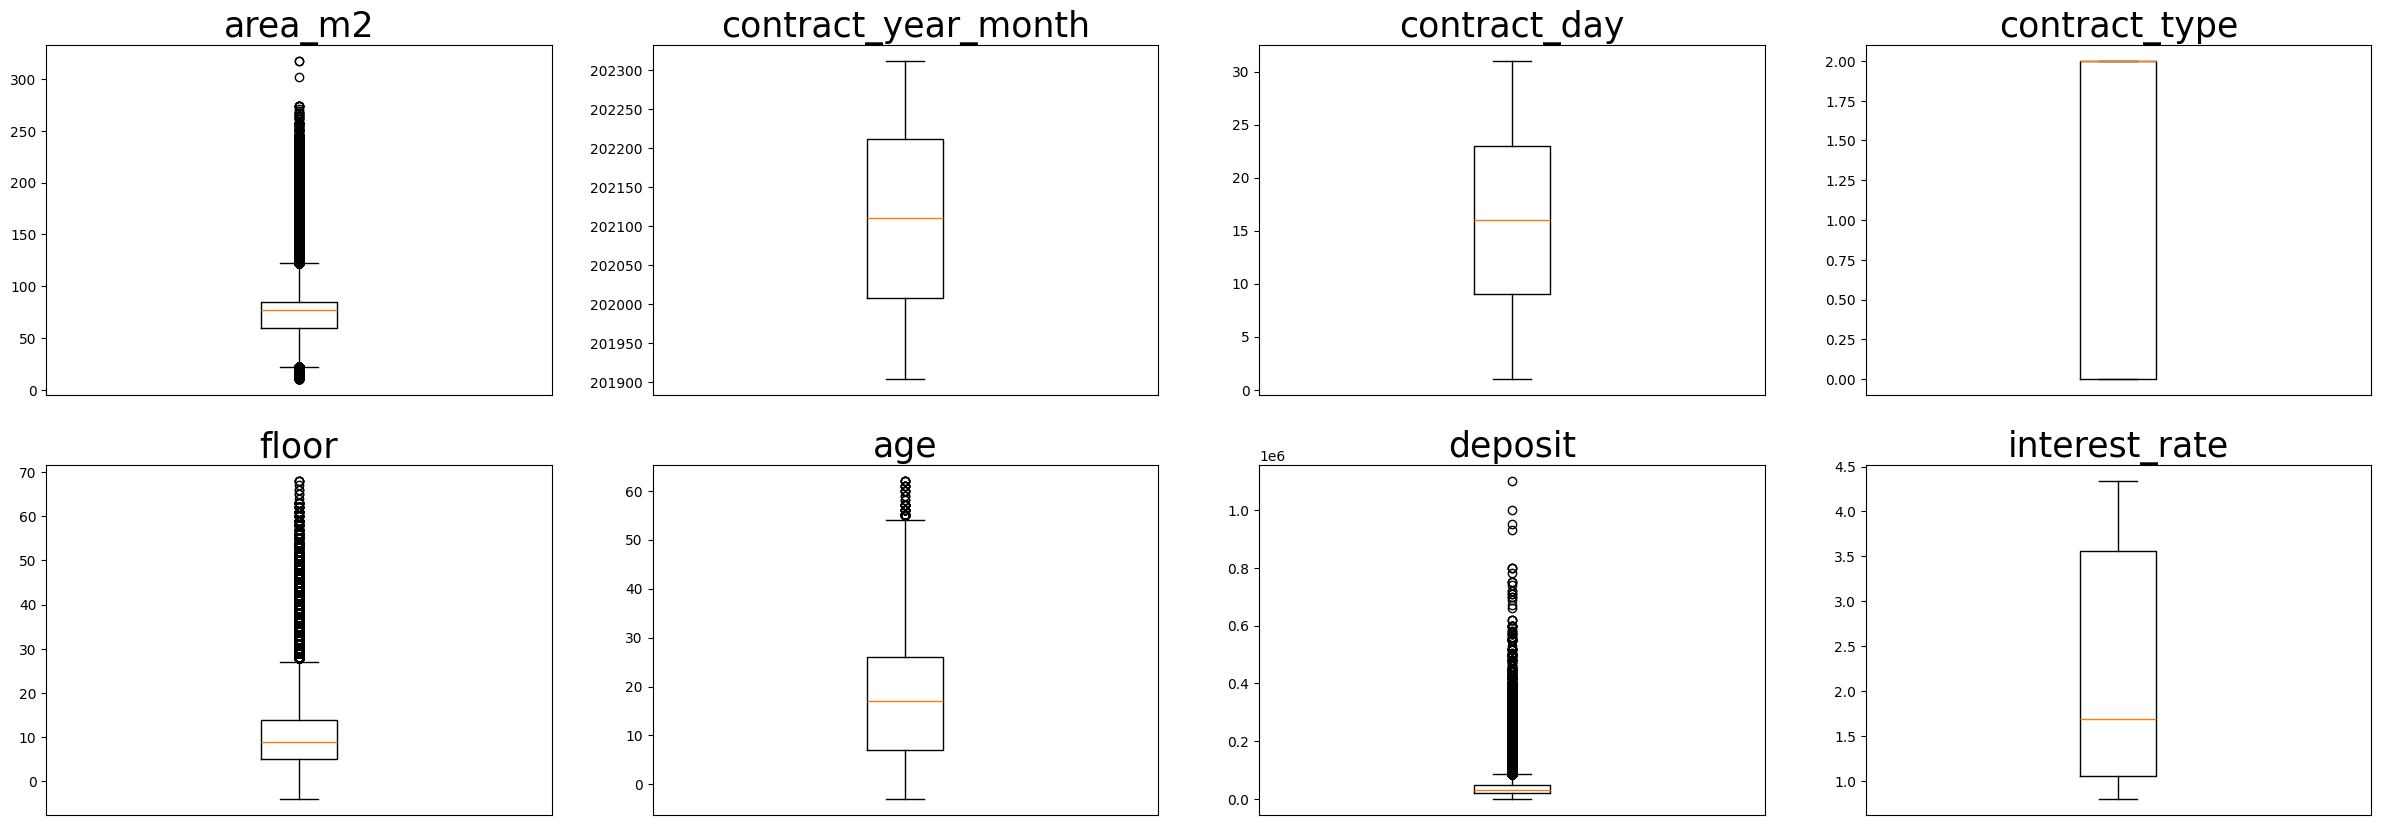

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 10))
axes = axes.flatten()

for i, column in enumerate(train_data.drop(columns=['index', 'longitude', 'latitude', 'built_year']).columns):
    axes[i].boxplot(train_data[column])
    axes[i].set_title(column, fontsize=25)
    axes[i].set_xticks([])

### 상관관계 확인

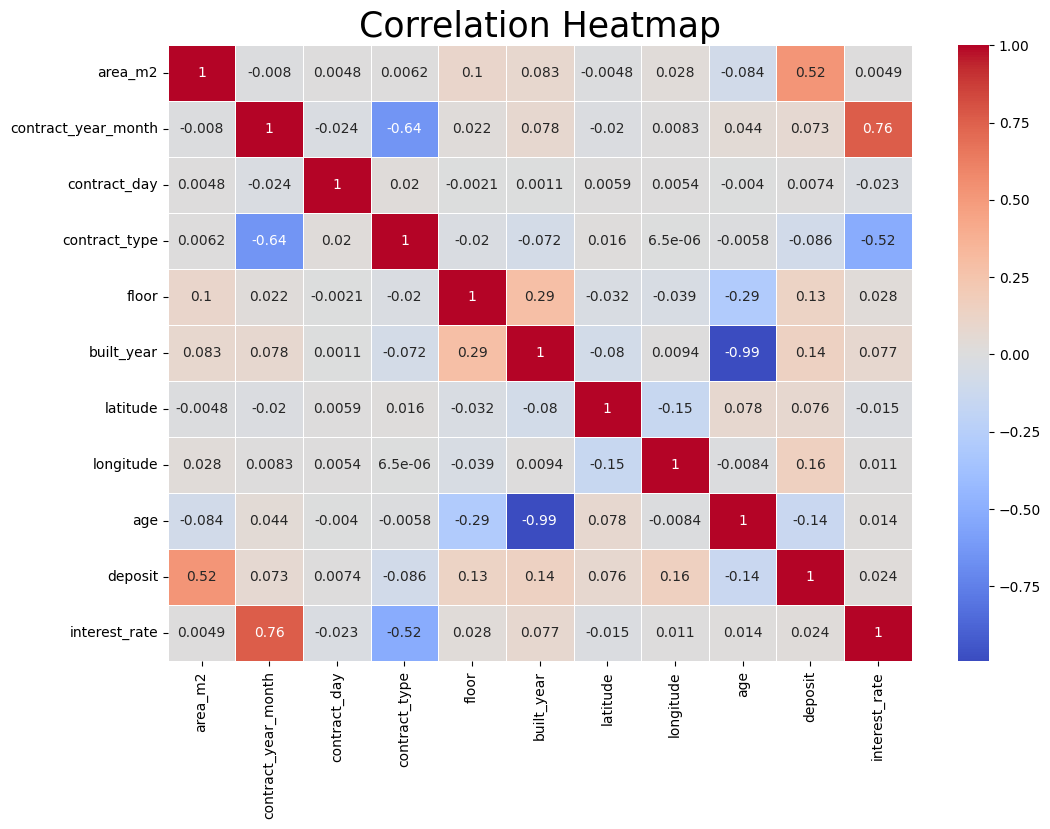

In [9]:
corr_matrix = train_data.drop(columns=['index']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=25)
plt.show()

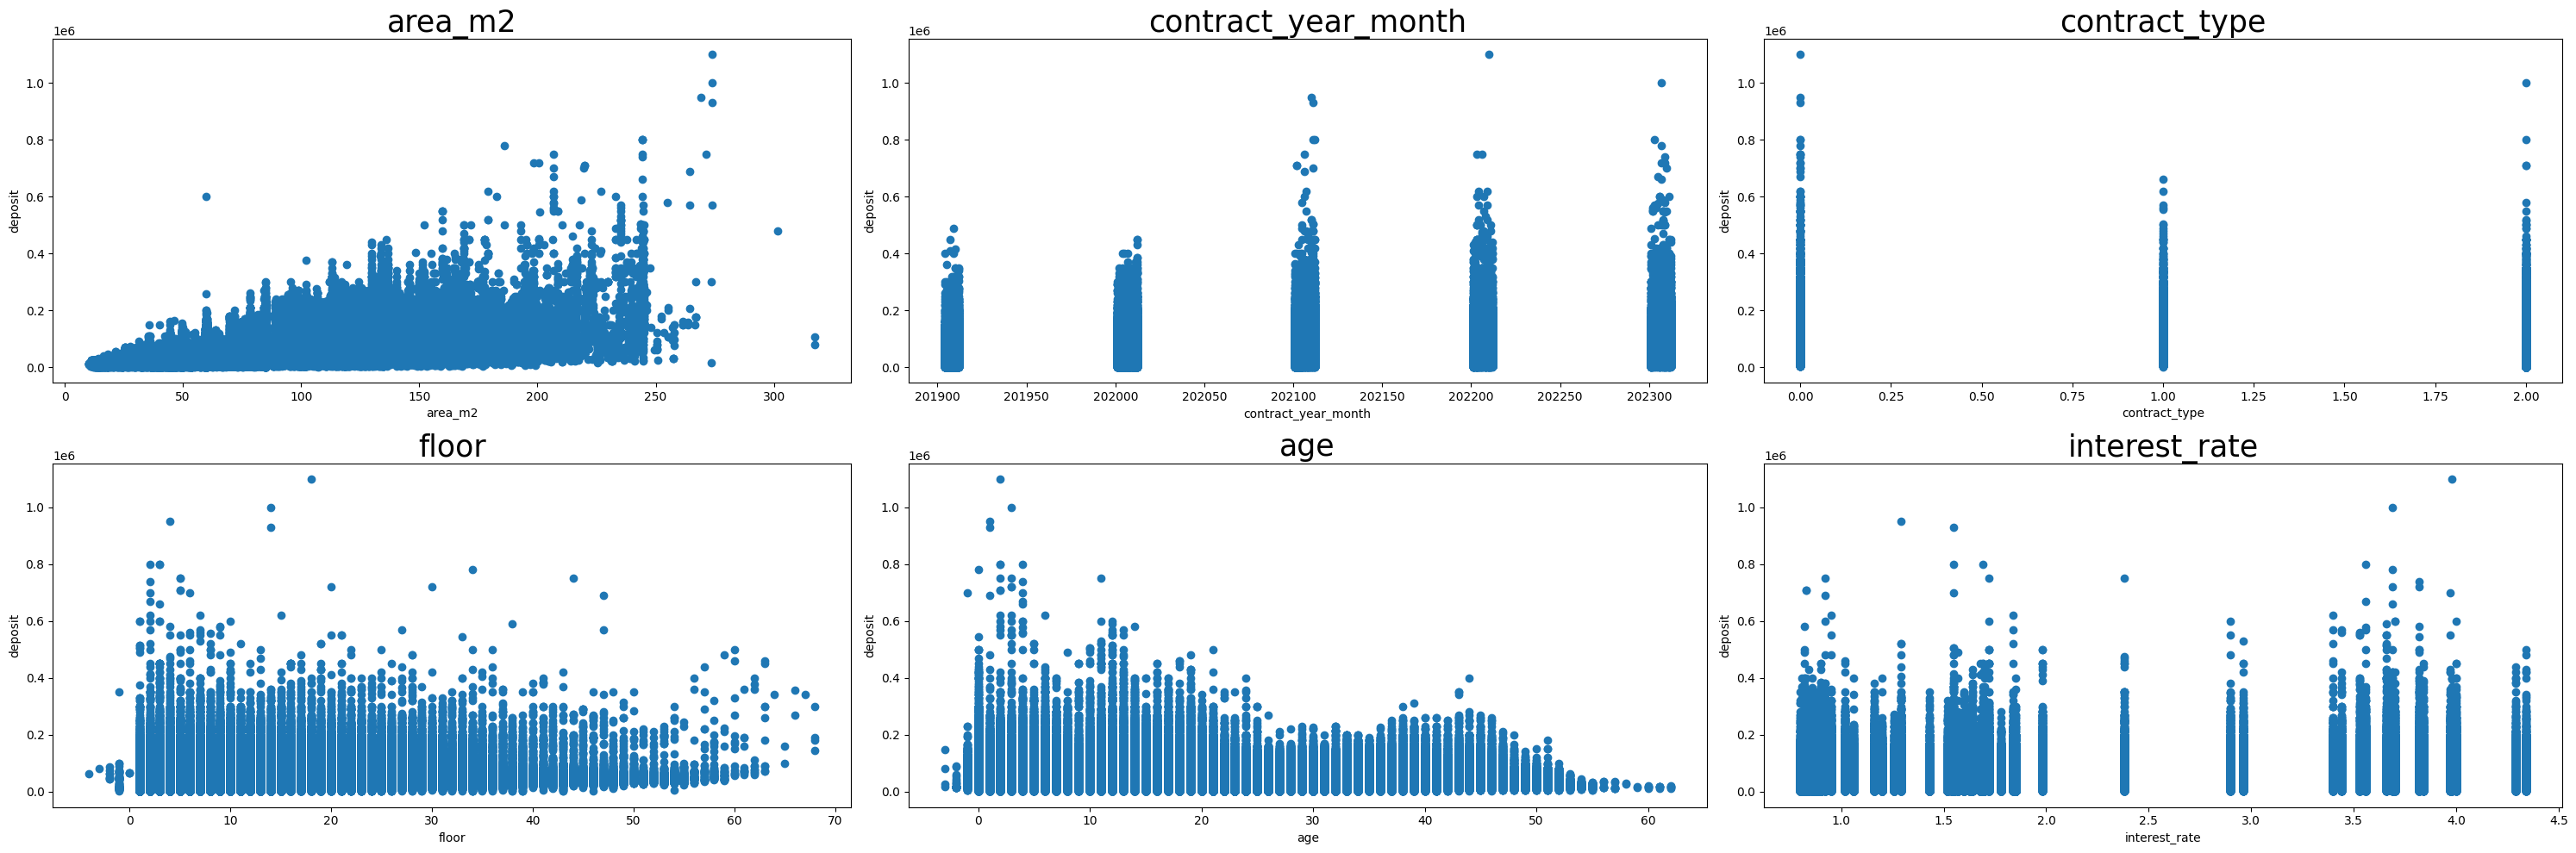

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
axes = axes.flatten()

for i, column in enumerate(train_data.drop(columns=['index', 'longitude', 'latitude', 'contract_day', 'deposit', 'built_year']).columns):
    axes[i].scatter(x=train_data[column], y=train_data['deposit'])
    axes[i].set_title(column, fontsize=25)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('deposit')

plt.tight_layout()

### 위도, 경도별 위치 시각화

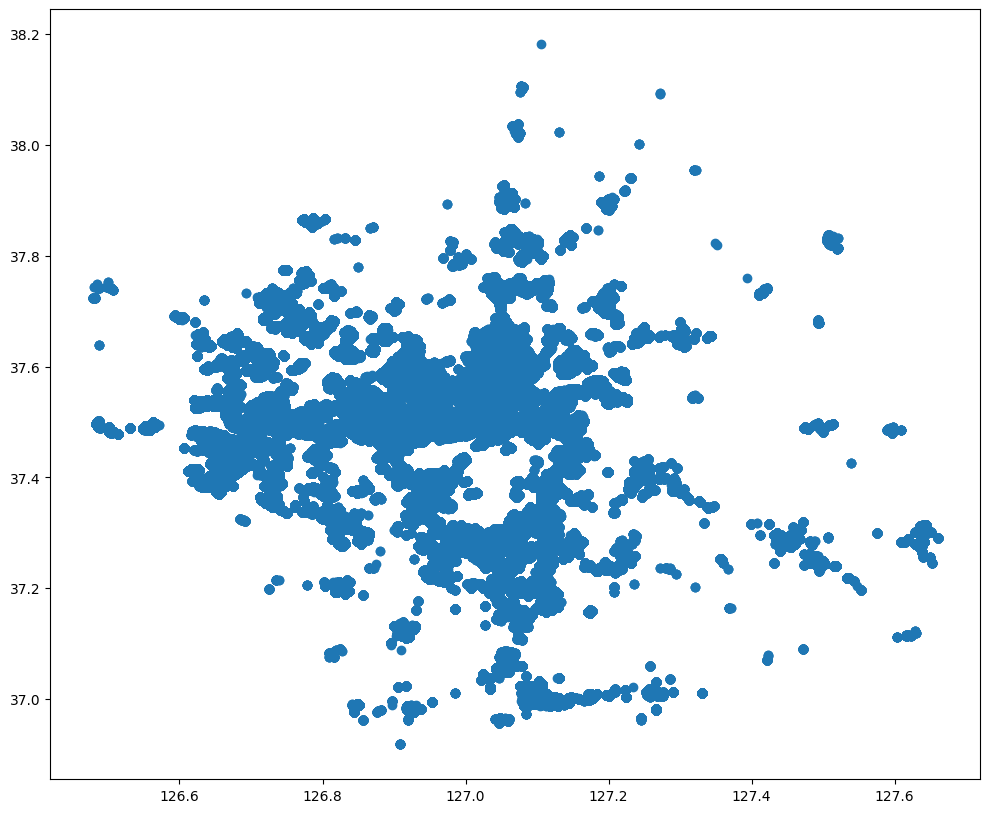

In [11]:
plt.figure(figsize=(12, 10))
plt.scatter(train_data['longitude'], train_data['latitude'])
plt.show()